### Mantle rheology

The goal of this notebook is to walk through mantle rheology if the form of dislocation and diffusion creep.

These contents are included(todo):

* Introduce flow law with the parameters for olivine defined in Hirth & Kohlstedt 2003
* An update on the parameters with new results (reference: explain_update_modHK03_rheology.pdf)

In [79]:
import numpy as np
from scipy.special import erf
from matplotlib import pyplot as plt

R = 8.314
year = 365.0 * 24.0 * 3600.0
eta_min = 1e18
eta_max = 1e25

#### Step 1: Define the parameters in flow law and view and example

##### 1.1 Form of the flow law

$\eta_{df, ds} = F \left(\frac{d^p}{A C^r_{OH}} \right)\dot{\epsilon_E}^{\frac{1-n}{n}}exp\left(\frac{E+P_{lc}V}{nRT}\right)$

Here F is a effective coefficient to account for the differences in the conditions in experiments.

In [80]:
def CreepRheology(creep_type, strain_rate, P, T, d=None, Coh=None, **kwargs):
    """
    def CreepRheology(creep_type, strain_rate, P, T, d, Coh):

    Calculate viscosity by flow law in form of (strain_rate)**(1.0 / n - 1) * (B)**(-1.0 / n) * np.exp((E + P * V) / (n * R * T))
    Units:
     - P: Pa
     - T: K
     - d: mu m
     - Coh: H / 10^6 Si
     - Return value: Pa*s
    Pay attention to pass in the right value, this custom is inherited
    """
    A = creep_type['A']
    p = creep_type['p']
    r = creep_type['r']
    n = creep_type['n']
    E = creep_type['E']
    V = creep_type['V']
    # compute value of F(pre factor)
    use_effective_strain_rate = kwargs.get('use_effective_strain_rate', False)
    if use_effective_strain_rate:
        F = 1 / (2**((n-1)/n)*3**((n+2)/2/n))
    else:
        F = 1.0

    if d is None:
        d = creep_type['d']
    if Coh is None:
        Coh = creep_type['Coh']
    # calculate B
    B = A * d**(-p) * Coh**r
    eta = 1/2.0 * F * (strain_rate)**(1.0 / n - 1) * (B)**(-1.0 / n) * np.exp((E + P * V) / (n * R * T)) * 1e6

    return eta






#### 1.2 The example from Hirth and Kohlstedt 2003, table 1

![](./HK03_table1.png)

In [81]:
# dislocation creep in Hirth & Kohlstedt 2003
HK03_disl = \
    {
        "A": 90,
        "p": 0.0,
        "r": 1.2,
        "n": 3.5,
        "E": 480e3,
        "V": 11e-6,
        "d" : 1e4,
        "Coh" : 1000.0
    }

# diffusion creep in Hirth & Kohlstedt 2003
HK03_diff = \
    {
        "A" : 1.0e6,
        "p" : 3.0,
        "r" : 1.0,
        "n" : 1.0,
        "E" : 335e3,
        "V" : 4e-6,
        "d" : 1e4,
        "Coh" : 1000.0
    }

# modified creep laws from Hirth & Kohlstedt 2003
# for detail, refer to magali's explain_update_modHK03_rheology.pdf file
HK03_wet_mod_diff = \
    {
        # "A" : 10**6.9,  # MPa^(-n-r)*um**p/s
        "A" : 7.1768e6,  # MPa^(-n-r)*um**p/s
        "p" : 3.0,
        "r" : 1.0,
        "n" : 1.0,
        "E" : 375e3,
        "V" : 23e-6,
        "d" : 1e4,
        "Coh" : 1000.0,
        "wet": 1.0  # I use this to mark this is a wet rheology, so I need to account for V and E for water later.
    }

HK03_wet_mod_disl = \
    {
        "A" : 10**2.65,
        "p" : 0.0,
        "r" : 1.0,
        "n" : 3.5,
        "E" : 520e3,
        "V" : 24e-6,
        "d" : 1e4,
        "Coh" : 1000.0,
        "wet" : 1.0
    }


To make sure our computation is valid, we can calculate the two examples given under table 1 directly.

The only difference is we are computing the viscosity, while the examples compute stress. In this way, we will mutiply our viscosity with 2 times the strain rate to get the stress to compare.

Note that this case shows the viscosity mantle is "highly deformed" even under 0.3 Mpa, as the strain rate from the dislocation creep already reaches $1 \times 10^{-12} s-1$

In [82]:
pressure = 1e9
temperature = 1673.0 # K
# diffusion creep
strain_rate = 7.8e-15
eta_diff = CreepRheology(HK03_diff, strain_rate, pressure, temperature)
stress = 2.0 * strain_rate * eta_diff
print("At strain rate = %.4e s-1, diffusion creep (COH = 1000) from Hirth & Kohlstedt 2003 gives viscosity = %.4e Pa*s, stress = %.4e Mpa"\
     % (strain_rate, eta_disl, stress/1e6))
# dislocation creep
strain_rate = 2.5e-12
eta_disl = CreepRheology(HK03_disl, strain_rate, pressure, temperature)
stress = 2.0 * strain_rate * eta_disl
print("At strain rate = %.4e s-1, dislocation creep (COH = 1000) from Hirth & Kohlstedt 2003 gives viscosity = %.4e Pa*s, stress = %.4e Mpa"\
     % (strain_rate, eta_disl, stress/1e6))

At strain rate = 7.8000e-15 s-1, diffusion creep (COH = 1000) from Hirth & Kohlstedt 2003 gives viscosity = 6.0174e+16 Pa*s, stress = 2.9977e-01 Mpa
At strain rate = 2.5000e-12 s-1, dislocation creep (COH = 1000) from Hirth & Kohlstedt 2003 gives viscosity = 6.0174e+16 Pa*s, stress = 3.0087e-01 Mpa


##### 1.3 Plot the  mantle rheologic profile with a temperature & pressure profile

Here, we first generate a temperature profile and a pressure profile.

The temperature profile is generated from the Half-space cooling model and a mantle adiabat.

The pressure profile, on the other hand, takes care of the density change due to thermal expansivity on the temperature profile.
The viscosity profile, is then computed on both T and P assuming some grain size.

TypeError: 'Text' object is not callable

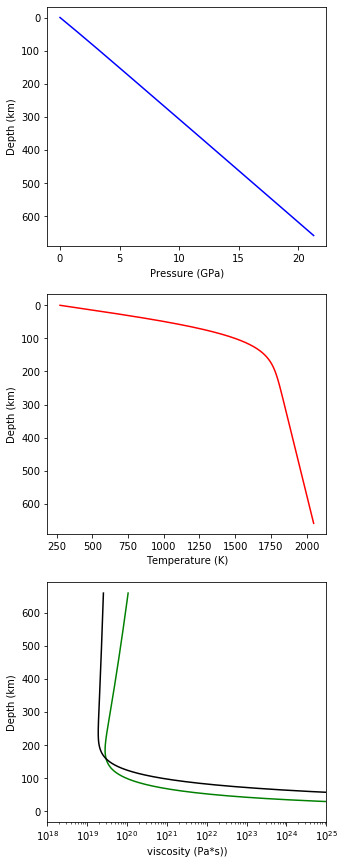

In [84]:

def pressure_from_lithostatic(z,Tad):
    '''
    A lithostatic pressure profile
    Inputs:
	z (float) - depth in m
	Tad (float) - adiabatic temperature
    '''
    # Density Profile
    refrho = 3300  # kg/m^3
    refT = 1673        # K
    alpha = 3.1e-5  # 1/K
    g = 9.81 # m/s^2
    density = refrho*(1-alpha*(Tad-refT))

    # start loop at 1 because P[0] = 0
    dz = z[1]-z[0]
    P = np.zeros(np.size(z))
    for i in range(1, np.size(z)):
        P[i] = P[i-1] + 0.5*(density[i]+density[i-1])*g*dz
    return P


def temperature_halfspace(z, t, **kwargs):
    '''
    temperature from a half-space cooling model
    Inputs:
	z (float) - depth (m)
	t - age (s)
    kwargs (dict):
        Tm (float) - mantle temperature
    '''
    # Physical constants
    kappa = 1e-6  # thermal diffusivity (m^2/s)
    T_s = 273  # surface temperature (K)
    T_m = kwargs.get("Tm", 1673) # mantle temperature (K)
    T = T_s + (T_m - T_s)*erf(z/(2*np.sqrt(kappa*t)))
    return T

strain_rate = 1e-15
zs = np.arange(0.0, 660.0, 1.0) * 1e3
age = 80e6 * year
Tad_surface = 1673.0 
mad = 0.5715  # deg/km, approximating adiabat to match T(CMB) in Aspect
Tads = Tad_surface + mad*(zs/1e3)
Ts = np.zeros(zs.shape)  # temperature, combine HS model with adiabat
for i in range(zs.size):
    z = zs[i]
    Tad = Tads[i]
    Ts[i] = temperature_halfspace(z, age, Tm = Tad)
Ps = pressure_from_lithostatic(zs, Ts)  # pressure, using the computed temperature
# compute viscosities
etas_disl = CreepRheology(HK03_disl, strain_rate, Ps, Ts)
etas_diff = CreepRheology(HK03_diff, strain_rate, Ps, Ts)
# plot figures
fig = plt.figure(figsize=(5, 15))
ax = fig.add_subplot(3, 1, 1)  # plot pressure
ax.plot(Ps/1e9, zs/1e3, 'b')
ax.set_xlabel("Pressure (GPa)")
ax.set_ylabel("Depth (km)")
ax.invert_yaxis()
ax = fig.add_subplot(3, 1, 2)  # plot temperature
ax.plot(Ts, zs/1e3, 'r')
ax.set_xlabel("Temperature (K)")
ax.set_ylabel("Depth (km)")
ax.invert_yaxis()
ax = fig.add_subplot(3, 1, 3)  # plot viscosity
ax.semilogx(etas_disl, zs/1e3, 'g', label="dislocation creep (HK03)")
ax.semilogx(etas_diff, zs/1e3, 'k', label="diffusion creep (HK03)")
ax.set_xlim([eta_min, eta_max])  # set x limit
ax.set_xlabel("viscosity (Pa*s))")
ax.set_ylabel("Depth (km)")
ax.title("Viscosity with limits")
ax.legend()
ax.invert_yaxis()
fig.tight_layout()

#### Step 2: derive a upper mantle viscosity profile for geodynamics

This are 2 things need to be done after Step 1 to reach a profile:
* 1. Apply yielding in the shallower parts.
* 2. At each depth, combine the computation of different flow laws.

There are both physical reason and numerical reason to have a yielding scheme at shallower depth.
Physically, the shallower part has much lower temperature, thus subjected to brittle deformation.
Numerically, the variation in viscosity a numerical code could handle is always limited (at best 7-8 orders).

### Read aspect depth_average file

I would be called later with the class function, so the class could know about the temperature and pressure profile

#### compute a lower mantle rheology for aspect